# Trabalho prático 2 - Classificação

### Davi Segundo - 417153 & Diego Holanda - 411627



## Bibliotecas e módulos utilizados no trabalho

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve

## Dataset

link para o dataset: [Obesity Dataset](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+)

### Descrição
The attributes related with eating habits are: Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS), other variables obtained were: Gender, Age, Height and Weight. Finally, all data was labeled and the class variable NObesity was created with the values of: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III, based on Equation (1) and information from WHO and Mexican Normativity. The data contains numerical data and continous data, so it can be used for analysis based on algorithms of classification, prediction, segmentation and association. Data is available in CSV format and ARFF format to be used with the Weka too

### Funções auxiliares

In [2]:
def show_metrics(results):
    accuracy = results["test_accuracy"].mean()
    recall = results["test_recall_macro"].mean()
    precision = results["test_precision_macro"].mean()
    print("----------------------")
    print(f"Accuracy_Mean:  {accuracy*100:.2f}%")
    print(f"Recall_Mean:    {recall*100:.2f}%")
    print(f"Precision_Mean: {precision*100:.2f}%")

### Configuração de plot dos gráficos

In [3]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Leitura e preparação dos dados

In [4]:
raw_data = pd.read_csv('./ObesityDataSet_raw_and_data_sinthetic.csv')
raw_data.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

### Transformação dos dados categóricos

In [5]:
category_consumption = ['no', 
                        'Sometimes', 
                        'Frequently', 
                        'Always'] 

category_transport = ['Automobile', 
                      'Motorbike', 
                      'Public_Transportation', 
                      'Bike', 'Walking']

obesity_level_encoder = LabelEncoder()

In [6]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(), ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']),
    (OrdinalEncoder(categories=[category_consumption, category_consumption]), ['CALC', 'CAEC']),
    (OrdinalEncoder(categories=[category_transport]), ['MTRANS']),
    remainder='passthrough'
)

### Separação do conjunto de treino e teste

In [7]:
train_set, test_set = train_test_split(raw_data, test_size=.2, random_state=42)

In [8]:
x_train = train_set.iloc[:, :-1]
y_train = obesity_level_encoder.fit_transform(train_set.NObeyesdad)

x_test = test_set.iloc[:, :-1]
y_test = obesity_level_encoder.transform(test_set.NObeyesdad)

## Paramêtros de otimização do GridSearch

In [9]:
logistic_parameters = {
    'model__penalty' : ['l2', 'none'],
    'model__multi_class' : ['ovr', 'multinomial'],
    'model__max_iter' : [500],
    'model__solver' : ['newton-cg']
}

tree_parameters = {
    'model__max_depth': [2,4,6,8,10,12],
    'model__criterion': ['gini', 'entropy']
}

knn_parameters = {
    'model__n_neighbors': [3, 5, 7, 8, 11],
    'model__weights' : ['uniform', 'distance'],
    'model__metric' : ['manhattan', 'euclidean', 'minkowski']
}

svc_parameters = {
    'model__C': [0.1, 1, 10, 100], 
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__kernel': ['rbf', 'poly', 'sigmoid']
}

## Regressão Logística

Regressão Logística é um modelo que usa a função sigmóide para mapear os dados de entrada para valores entre 0 e 1, o que possibilita modelar a probabilidade de uma certa entrada $x$ pertencer a uma classe $K$ como uma distribuição de Bernoulli. Esse modelo foi originalmente desenvolvido para casos de classificação binária, porém podemos a estratégia de `one vs all` para modelar casos multiclasse.

A parte mais interessante é que apesar de ser usado para a regressão, os algoritmos de GD e SGD também podem ser usados para encontrar os pesos ótimos de forma iterativa.

In [10]:
model = LogisticRegression()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = logistic_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       5.940158      2.674439         0.005785        0.001163   
2       0.098838      0.009389         0.006782        0.001596   
1       0.146274      0.013032         0.007386        0.001026   
0       0.106516      0.007552         0.008377        0.001017   

  param_model__max_iter param_model__multi_class param_model__penalty  \
3                   500              multinomial                 none   
2                   500              multinomial                   l2   
1                   500                      ovr                 none   
0                   500                      ovr                   l2   

  param_model__solver                                             params  \
3           newton-cg  {'model__max_iter': 500, 'model__multi_class':...   
2           newton-cg  {'model__max_iter': 500, 'model__multi_class':...   
1           newton-cg  {'model__max_iter': 500, 'model__multi_class':...   
0           newton-cg  {'model__max_iter': 500, 'model__multi_class':...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
3           0.949704           0.940828           0.920118           0.940653   
2           0.872781           0.872781           0.857988           0.839763   
1           0.766272           0.772189           0.754438           0.768546   
0           0.745562           0.757396           0.739645           0.738872   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
3           0.964392         0.943139        0.014396                1  
2           0.863501         0.861363        0.012192                2  
1           0.798220         0.771933        0.014427                3  
0           0.756677         0.747631        0.008024                4

In [11]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  89.83%
Recall_Mean:    89.63%
Precision_Mean: 89.89%


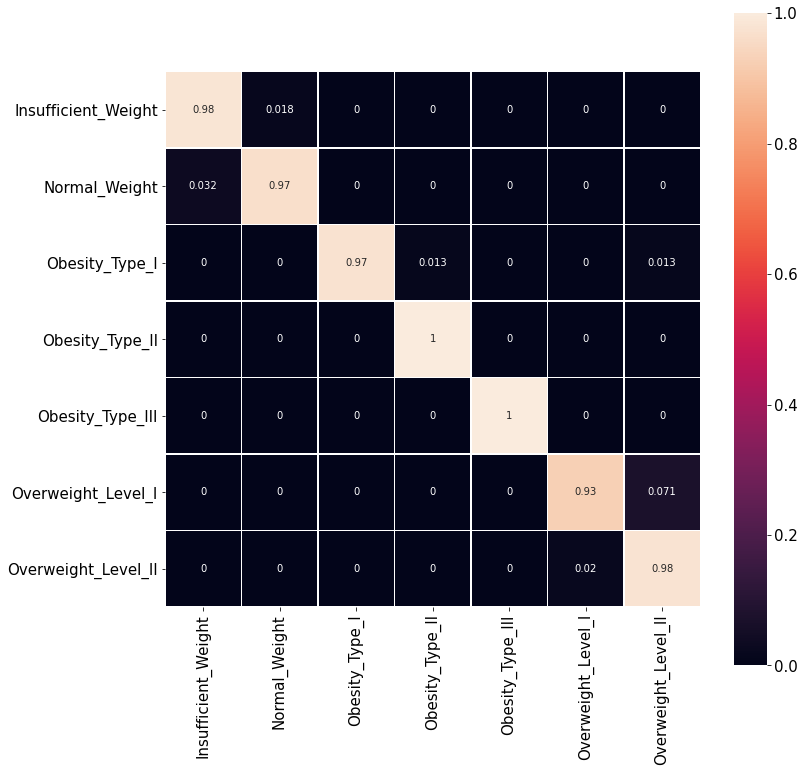

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## Árvore de Decisão

Árvores de decisão se baseiam na ideia de nós podermos dividir nossos espaços de decisão por meio de premissas lógicas `se...então..`, essa divisão é então codificada em formato de árvore de forma que as folhas representam a classe (ou valor no caso da regressão) predito e os nós internos representam as regras lógicas aplicadas sobre um atributo específico.

### Como construir a árvore a partir dos atributos?
Calcular a árvore ótima (menor profundidade) é um problema NP-difícil, o que seria inviável para algoritmos de treinamento. Sendo assim, árvores de decisão se baseiam em uma heurística gulosa sobre `índices de pureza`, ou seja, encontramos tentamos encontrar o atributo que melhor divide o espaço naquele momento.

### O que são índices de pureza?
Índices de pureza são uma forma de mensurar quão consistente é a nossa divisão, no caso quanto maior o nosso índice de pureza melhor, visto que o nosso espaço possui vários elementos do mesmo tipo, ou seja, é mais consistente.

A árvore de decisão do `sklearn` possui dois possíveis critérios para o índice de pureza: `gini` e `entropy`.

### Overfitting
É importante ficar atento à profundidade da nossa árvore, visto que, desconsiderando o ruído podemos dividir nosso espaço de decisão de maneira arbitrariamente pequena, o que prejudica a generalização do modelo criando divisões extremamente específicas.

Podemos usar grid search sobre a profundidade máxima da árvore para encontrar um tamanho que generalize bem os dados sem causar overfitting.

In [13]:
model = DecisionTreeClassifier()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = tree_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       0.021444      0.001857         0.006975        0.001257   
9        0.019344      0.001015         0.004987        0.000631   
10       0.019748      0.000975         0.006190        0.000976   
5        0.017347      0.003380         0.005585        0.001197   
4        0.015361      0.000797         0.005384        0.000486   
3        0.016959      0.003551         0.005783        0.001324   
2        0.014759      0.000416         0.004594        0.000482   
8        0.019351      0.000486         0.005583        0.001019   
1        0.014938      0.002198         0.006374        0.001014   
7        0.018246      0.001727         0.005792        0.000748   
0        0.012359      0.000786         0.005785        0.001828   
6        0.013968      0.000026         0.005393        0.000484   

   param_model__criterion param_model__max_depth  \
11                entropy                     12   
9                 entropy                      8   
10                entropy                     10   
5                    gini                     12   
4                    gini                     10   
3                    gini                      8   
2                    gini                      6   
8                 entropy                      6   
1                    gini                      4   
7                 entropy                      4   
0                    gini                      2   
6                 entropy                      2   

                                               params  split0_test_score  \
11  {'model__criterion': 'entropy', 'model__max_de...           0.934911   
9   {'model__criterion': 'entropy', 'model__max_de...           0.928994   
10  {'model__criterion': 'entropy', 'model__max_de...           0.928994   
5   {'model__criterion': 'gini', 'model__max_depth...           0.923077   
4   {'model__criterion': 'gini', 'model__max_depth...           0.926036   
3   {'model__criterion': 'gini', 'model__max_depth...           0.911243   
2   {'model__criterion': 'gini', 'model__max_depth...           0.872781   
8   {'model__criterion': 'entropy', 'model__max_de...           0.890533   
1   {'model__criterion': 'gini', 'model__max_depth...           0.754438   
7   {'model__criterion': 'entropy', 'model__max_de...           0.775148   
0   {'model__criterion': 'gini', 'model__max_depth...           0.562130   
6   {'model__criterion': 'entropy', 'model__max_de...           0.553254   

    split1_test_score  split2_test_score  split3_test_score  \
11           0.967456           0.949704           0.940653   
9            0.946746           0.952663           0.940653   
10           0.964497           0.937870           0.943620   
5            0.923077           0.914201           0.934718   
4            0.914201           0.911243           0.934718   
3            0.920118           0.914201           0.916914   
2            0.884615           0.923077           0.878338   
8            0.863905           0.899408           0.875371   
1            0.792899           0.781065           0.765579   
7            0.751479           0.739645           0.729970   
0            0.556213           0.547337           0.551929   
6            0.553254           0.550296           0.551929   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
11           0.955490         0.949643        0.011396                1  
9            0.949555         0.943722        0.008360                2  
10           0.931751         0.941346        0.012632                3  
5            0.949555         0.928926        0.012201                4  
4            0.934718         0.924183        0.009925                5  
3            0.905045         0.913504        0.005149                6  
2            0.913947         0.894552        0.020127                7  
8            0.902077         0.886259   

In [14]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  85.35%
Recall_Mean:    85.20%
Precision_Mean: 85.74%


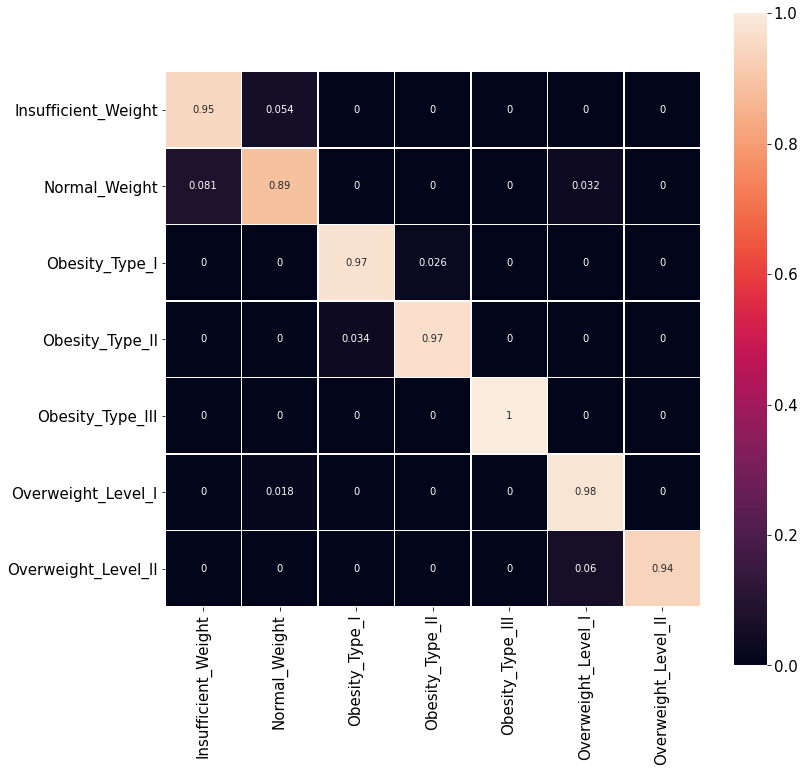

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## KNN

KNN é um modelo não paramétrico que busca calcular a classe do elemento de entrada $x$ baseado na classe dos elementos mais próximos de $x$. Esse modelo é, portanto, baseado em dois principais Hiperparâmetros: a função de distância e a quantidade (K) de vizinhos.

In [16]:
model = KNeighborsClassifier()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = knn_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3        0.016164      0.000734         0.020937        0.002443   
1        0.016877      0.001676         0.018335        0.001725   
5        0.016156      0.001167         0.018753        0.001921   
0        0.024945      0.017956         0.028341        0.004247   
7        0.020150      0.001462         0.022540        0.002653   
2        0.016766      0.001938         0.028312        0.003495   
9        0.014759      0.000386         0.018545        0.000471   
4        0.015366      0.000496         0.027715        0.001705   
21       0.014567      0.000801         0.016567        0.000494   
11       0.014950      0.000896         0.016563        0.000804   
6        0.015686      0.000622         0.029033        0.004944   
13       0.018866      0.002901         0.021528        0.003367   
23       0.017267      0.000885         0.018459        0.001612   
10       0.015159      0.000976         0.025531        0.001846   
20       0.015937      0.001100         0.026852        0.000998   
27       0.017764      0.003167         0.020137        0.002488   
17       0.015546      0.000798         0.019149        0.001461   
8        0.016564      0.003761         0.026528        0.001354   
25       0.015369      0.000998         0.017758        0.001937   
15       0.016157      0.001298         0.018758        0.000750   
29       0.015733      0.001141         0.018956        0.002517   
19       0.014754      0.000735         0.018159        0.000736   
22       0.019156      0.003645         0.035305        0.005748   
12       0.018140      0.001316         0.029333        0.004418   
24       0.014572      0.000797         0.026547        0.001221   
14       0.016269      0.000973         0.026736        0.001326   
16       0.014868      0.000644         0.026630        0.001694   
26       0.014570      0.000496         0.026913        0.001097   
18       0.017360      0.001491         0.030718        0.002612   
28       0.014960      0.000631         0.026330        0.001011   

   param_model__metric param_model__n_neighbors param_model__weights  \
3            manhattan                        5             distance   
1            manhattan                        3             distance   
5            manhattan                        7             distance   
0            manhattan                        3              uniform   
7            manhattan                        8             distance   
2            manhattan                        5              uniform   
9            manhattan                       11             distance   
4            manhattan                        7              uniform   
21           minkowski                        3             distance   
11           euclidean                        3             distance   
6            manhattan                        8              uniform   
13           euclidean                        5             distance   
23           minkowski                        5             distance   
10           euclidean                        3              uniform   
20           minkowski                        3              uniform   
27           minkowski                        8             distance   
17           euclidean                        8             distance   
8            manhattan                       11              uniform   
25           minkowski                        7             distance   
15           euclidean                        7             distance   
29           minkowski                       11             distance   
19           euclidean                       11             distance   
22           minkowski                        5              uniform   
12           euclidean                        5              uniform   
24           minkowski                        7              uniform   
14           euclidean 

In [17]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

display(results)

show_metrics(results)

{'fit_time': array([0.0109446 , 0.00797844, 0.00900793, 0.00893855, 0.00973868]),
 'score_time': array([0.00797153, 0.00798035, 0.00997782, 0.00797844, 0.00698066]),
 'test_accuracy': array([0.75294118, 0.74117647, 0.72941176, 0.82142857, 0.73809524]),
 'test_recall_macro': array([0.74434316, 0.72840909, 0.73376623, 0.81017316, 0.7461705 ]),
 'test_precision_macro': array([0.73504274, 0.77531744, 0.74878129, 0.84181097, 0.7541257 ])}

----------------------
Accuracy_Mean:  75.66%
Recall_Mean:    75.26%
Precision_Mean: 77.10%


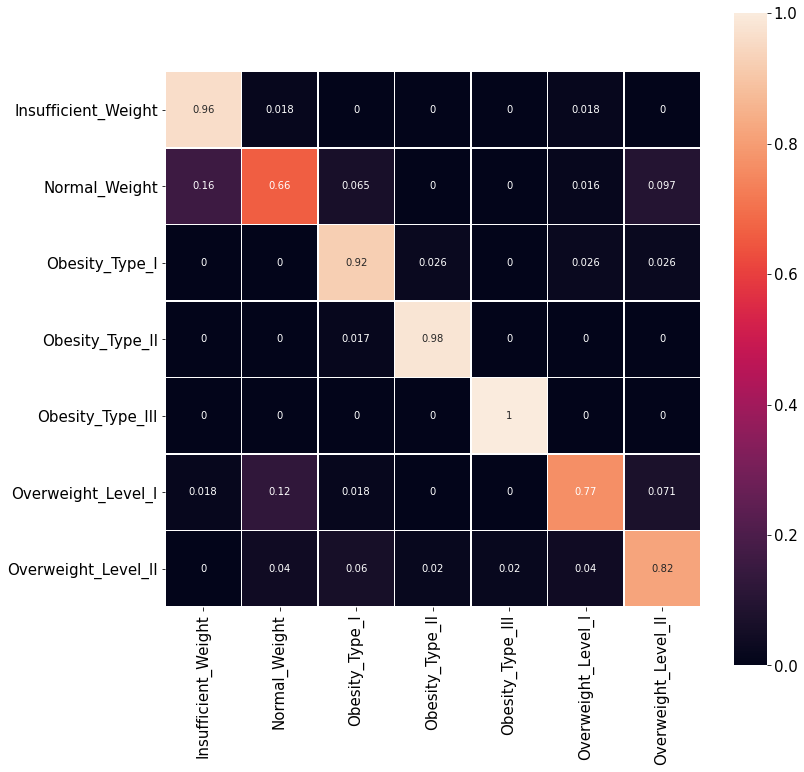

In [18]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## SVC (Support Vector Classification)

A idea básica por trás do SVC é mapear as nossas entradas para dimensões maiores, calcular a relação entre as entradas nas novas dimensões e encontrar um hiperplano que consegue separar os nossos dados na dimensão superior. Dessa forma, podemos facilmente detectar a que classe o elemento pertence.

Vamos tentar entender como chegar ao SVC a partir de ideias de algoritmos mais simples. A explicação vai ser voltada para classificação binária, mas ele pode ser extrapolado usando a ideia de one vs one.

### Margin, Maximal Margin Classifier

Maximal Margin Classifier se baseia na ideia de usar os pontos na fronteira das classes para calcular um ponto, linha ou hiperplano (depende da dimensão) que separa as duas classes. Mas especificamente, o hiperplano que separa as duas classes é chamado de margem e o Maximal Margin Classifier é quando nós usamos a maior margem para os nossos dados.

Esse modelo tem a desvantagem de ser fortemente influenciado por outliers e só conseguir resolver problemas linearmente separáveis.

### Soft Margin, Suport Vector Classifier

Soft Margin é a forma que temos de combater o primeiro problema do Maximal Margin Classifer, os outliers. Nesse caso, nós tentamos definir um hiperplano que seja menos sensível ao treino, ou seja, alguns dados podem acabar sendo classificados de forma errada, mas que tem maior potencial de generalização.

Quando usamos soft margin para classificar os dados estamos o modelo Suport Vector Classifier. Esse nome vem do fato dos dados da fronteira de dentro da classe usados para calcular a soft margin serem chamados de suport vectors.

### Kernel

Agora vamos resolver para o caso onde os dados não são linearmente separáveis usando Vector Machines. Nesse caso, o que nós vamos fazer é usar um função de kernel para aumentar as dimensões dos nossos dados e vamos um Suport Vector Classifer nessa dimensão superior.

### Vantagens
- Funciona para dados semi ou não estruturados
- Efetivo nos casos onde temos mais atributos do que observações

### Desvantagens
- Dificuldade de escolha de função de kernel
- Não é muito eficiente para datasets com muitas observações
- Pode ser difícil de tunar os hiperparâmetros C e gamma visto que o impacto é difícil de perceber

In [19]:
model = svm.SVC()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = svc_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
42       0.060026      0.004172         0.012161        0.000740   
45       0.063835      0.004682         0.016355        0.002326   
30       0.053265      0.001358         0.014351        0.000495   
27       0.071280      0.001716         0.015155        0.000746   
39       0.076211      0.003821         0.014949        0.000618   
28       0.050735      0.001684         0.010329        0.000456   
47       0.069019      0.006751         0.020740        0.002982   
15       0.070006      0.002132         0.016160        0.001163   
1        0.051661      0.001952         0.010976        0.000021   
25       0.048773      0.001549         0.010171        0.000398   
37       0.053457      0.004165         0.010779        0.001318   
40       0.050065      0.001621         0.009577        0.000477   
13       0.052624      0.008654         0.011757        0.002223   
16       0.051984      0.001296         0.012175        0.001584   
44       0.061329      0.007240         0.013769        0.000419   
32       0.059264      0.002958         0.017156        0.000738   
36       0.141152      0.005501         0.018146        0.001169   
24       0.139553      0.004361         0.017447        0.000657   
12       0.134046      0.003232         0.017462        0.000462   
18       0.064629      0.000962         0.018729        0.000740   
33       0.068622      0.004290         0.018552        0.001361   
43       0.062423      0.001477         0.014165        0.000397   
4        0.064444      0.003064         0.014737        0.000751   
3        0.095068      0.005883         0.020142        0.002029   
35       0.079499      0.003586         0.022347        0.001352   
20       0.079414      0.004087         0.021133        0.000986   
5        0.097736      0.012816         0.024747        0.001715   
21       0.105913      0.003054         0.021142        0.001141   
6        0.110339      0.002135         0.021934        0.001275   
17       0.062478      0.006036         0.019157        0.000745   
29       0.047473      0.002787         0.017352        0.000489   
41       0.044027      0.001304         0.016953        0.000639   
31       0.084305      0.008680         0.016276        0.000890   
8        0.123311      0.001552         0.025227        0.002941   
23       0.121091      0.001191         0.024516        0.002227   
0        0.128495      0.005022         0.020977        0.001062   
2        0.126554      0.004241         0.031522        0.003059   
14       0.099531      0.004973         0.027334        0.001001   
26       0.095357      0.002593         0.028023        0.001569   
38       0.095040      0.003557         0.026929        0.000620   
19       0.085290      0.005185         0.016353        0.000803   
46       0.094950      0.006626         0.017949        0.001405   
22       0.081607      0.002184         0.016962        0.001526   
11       0.130559      0.002780         0.024549        0.001611   
10       0.081235      0.002719         0.015759        0.000398   
9        0.124474      0.004231         0.020934        0.000656   
7        0.087256      0.005576         0.017936        0.003032   
34       0.084752      0.003085         0.016966        0.001087   

   param_model__C param_model__gamma param_model__kernel  \
42            100               0.01                 rbf   
45            100              0.001                 rbf   
30             10               0.01                 rbf   
27             10                0.1                 rbf   
39            100                0.1                 rbf   
28             10                0.1                poly   
47            100              0.001             sigmoid   
15              1                0.1                 rbf   
1             0.1                  1                poly   
25             10                  1                poly   
37         

In [20]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  87.47%
Recall_Mean:    86.79%
Precision_Mean: 87.00%


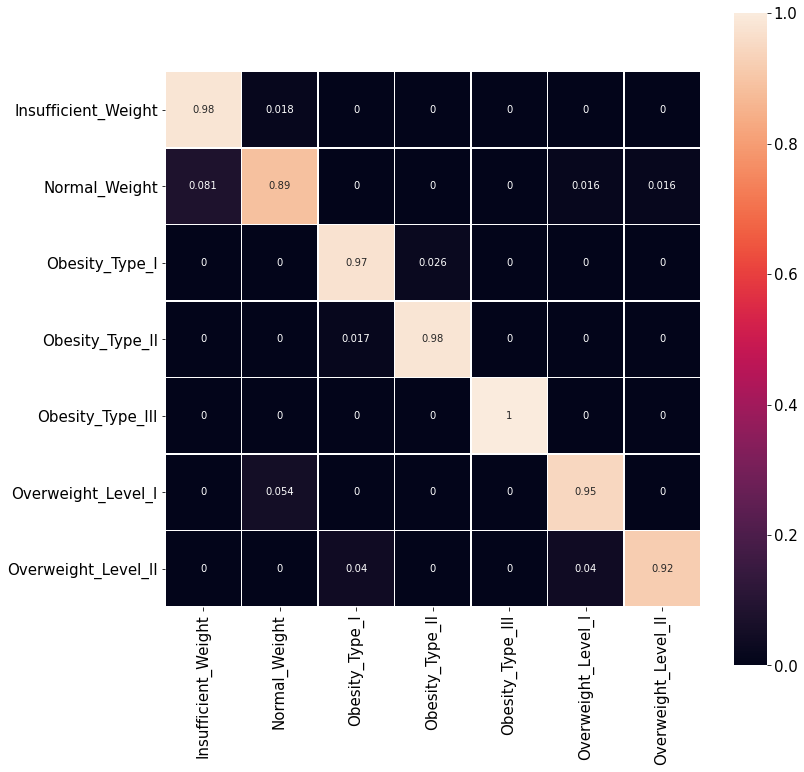

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);